In [ ]:
import os
import json
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from datetime import datetime
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model


#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [ ]:


DATA_DIR  = os.path.join(os.getcwd(), 'data')

MODEL_DIR = os.path.join(os.getcwd(), 'models')
MODEL_TYPE = 'classifier'  # 'classifier' or 'diagnosis'

EPOCHS = 50
PATIENCE =  int(EPOCHS * 0.2) # Early stopping patience set to 20% of epochs

LEARNING_RATE = 0.001
BETA_1 = 0.800
BETA_2 = 0.999

RANDOM_STATE = 42
IMG_SIZE = (149, 149)
BATCH_SIZE = 32

In [33]:
def init_model_dir(model_type, model_name, base_dir="models"):
    date_str = datetime.now().strftime("%Y%m%d-%H%M")
    dir_path = os.path.join(base_dir, model_type, f"{model_name}-{date_str}")
    os.makedirs(dir_path, exist_ok=True)
    return dir_path

model_dir = init_model_dir(MODEL_TYPE.lower(), f"cortex-{MODEL_TYPE.lower()}-model")


In [34]:
for device in tf.config.list_physical_devices():
    if device.device_type == 'GPU':
        tf.config.experimental.set_memory_growth(device, True)
        print(f"Using GPU: {device.name}")
    else:
        print(f"Using CPU: {device.name}")

print("TensorFlow version:", tf.__version__)

Using CPU: /physical_device:CPU:0
Using GPU: /physical_device:GPU:0
TensorFlow version: 2.16.2


In [35]:
train_dir = os.path.join(DATA_DIR, 'train')
test_dir = os.path.join(DATA_DIR, 'test')

# Check if the directories exist
if not os.path.exists(DATA_DIR):
    print(f"Data directory does not exist: {DATA_DIR}")
if not os.path.exists(train_dir):
    print(f"Training directory does not exist: {train_dir}")
if not os.path.exists(test_dir):
    print(f"Test directory does not exist: {test_dir}")

# Load the training data
train_images = glob(os.path.join(train_dir, '*/*.jpg'))
if not train_images:
    print(f"No training images found in: {train_dir}")
# Load the test data
test_images = glob(os.path.join(test_dir, '*/*.jpg'))
if not test_images:
    print(f"No test images found in: {test_dir}")   
# Display the number of images in each set
print(f"Number of training images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of training images: 5712
Number of test images: 1311


In [36]:
def data_classifier(path: str) -> pd.DataFrame:
    img_paths = glob(os.path.join(path, '*/*.jpg'))
    labels = [os.path.basename(os.path.dirname(p)) for p in img_paths]
    df = pd.DataFrame(list(zip(img_paths, labels)), columns=['image_path', 'label'])
    return df



# Load datasets
df_trn_full = data_classifier(train_dir)
df_tst = data_classifier(test_dir)

# Normalize class labels
if MODEL_TYPE.lower() == 'classifier':
    df_trn_full["label"] = df_trn_full["label"].apply(lambda x: 'normal' if x == 'notumor' else 'abnormal')
    df_tst["label"] = df_tst["label"].apply(lambda x: 'normal' if x == 'notumor' else 'abnormal')

# Split training data into training and validation
df_trn, df_val = train_test_split(
    df_trn_full, test_size=0.1, random_state=RANDOM_STATE, stratify=df_trn_full['label']
)

print(f"Training data shape: {df_trn.shape}")
print(f"Validation data shape: {df_val.shape}")
print(f"Test data shape: {df_tst.shape}")

Training data shape: (5140, 2)
Validation data shape: (572, 2)
Test data shape: (1311, 2)


In [37]:
_generator = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1] 
    brightness_range=[0.8, 1.2], # Randomly adjust brightness
)




train_generator = _generator.flow_from_dataframe(
    dataframe=df_trn,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use categorical labels for multi-class classification
    shuffle=False,

    width_shift_range=0.1, # Randomly shift images horizontally
    height_shift_range=0.1, # Randomly shift images vertically
    rotation_range=25, # Randomly rotate images
    zoom_range=0.2, # Randomly zoom images
    horizontal_flip=True, # Randomly flip images horizontally
    vertical_flip=True, # Do not flip images vertically
    brightness_range=[0.8, 1.2], # Randomly adjust brightness
    seed=RANDOM_STATE,
    color_mode='rgb', # Use RGB color mode
)
val_generator = _generator.flow_from_dataframe(
    dataframe=df_val,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use categorical labels for multi-class classification
    shuffle=False,
    seed=RANDOM_STATE,
    color_mode='rgb', # Use RGB color mode
)
test_generator = _generator.flow_from_dataframe(
    dataframe=df_tst,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use categorical labels for multi-class classification
    shuffle=False,
    seed=RANDOM_STATE,
    color_mode='rgb', # Use RGB color mode
)

Found 5140 validated image filenames belonging to 2 classes.
Found 572 validated image filenames belonging to 2 classes.
Found 1311 validated image filenames belonging to 2 classes.


In [38]:
N_TYPES = len(train_generator.class_indices)


model = Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu", kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu", kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu", kernel_regularizer=l2(0.001)),
    #MaxPooling2D(pool_size=(3, 3)),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.5, seed=RANDOM_STATE),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 146, 146, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494,946 (1.89 MB)

 Trainable params: 494,946 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
summary = []

summary.append("================== Model Metadata ================")
summary.append("Model Metadata:")
summary.append(f"  TensorFlow version: {tf.__version__}")
summary.append(f"  Model directory: {MODEL_DIR}")
summary.append(f"  Model type: {MODEL_TYPE}")
summary.append(f"  Model name: cortex-classifier")
summary.append(f"  Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
summary.append(f"  Model directory: {model_dir}")
summary.append(f"  Epochs: {EPOCHS}")
summary.append(f"  Batch size: {BATCH_SIZE}" )
summary.append(f"  Patience: {PATIENCE}")
summary.append(f"  Number of classes: {N_TYPES}")
summary.append(f"  Image size: {IMG_SIZE[0]}x{IMG_SIZE[1]}")
summary.append(f"  Number of training images: {len(df_trn)* BATCH_SIZE}")
summary.append(f"  Number of validation images: {len(df_val)* BATCH_SIZE}")
summary.append(f"  Number of test images: {len(df_tst)* BATCH_SIZE}")
summary.append(f"  Optimizer: {optimizer.__class__.__name__}")
summary.append(f"  Loss function: {model.loss}")
summary.append("="*50)
summary.append("Model architecture:")
summary.append(model.to_json())
summary.append("="*50)
summary.append("Model summary:")
model.summary(print_fn=lambda x: summary.append(x))
summary.append("="*50)
summary.append("Model training parameters:")
def get_value(x):
    return x.numpy() if hasattr(x, "numpy") else x

summary.append(f"  Learning rate: {get_value(optimizer.learning_rate)}")
summary.append(f"  Beta 1: {get_value(optimizer.beta_1)}")
summary.append(f"  Beta 2: {get_value(optimizer.beta_2)}")
summary.append(f"  Loss function: {model.loss}")
summary.append(f"  Metrics: {model.metrics_names}")
summary.append(f"  Regularization: {model.layers[0].kernel_regularizer.get_config() if model.layers[0].kernel_regularizer else 'None'}")
summary.append("="*50)

# Print the summary to the console
for line in summary:
    print(line)    

summary_file = os.path.join(model_dir, 'model_summary.txt')
with open(summary_file, 'w') as f:
    for line in summary:
        f.write(line + '\n')

================== Model Metadata ================
Model Metadata:
  TensorFlow version: 2.16.2
  Model directory: /Users/dheebz/Workspace/cortex/models
  Model type: classifier
  Model name: cortex-classifier
  Date: 2025-06-09 13:56:32
  Model directory: models/classifier/cortex-classifier-model-20250609-1356
  Epochs: 50
  Batch size: 32
  Patience: 10
  Number of classes: 2
  Image size: 149x149
  Number of training images: 164480
  Number of validation images: 18304
  Number of test images: 41952
  Optimizer: Adam
  Loss function: categorical_crossentropy
Model architecture:
{"module": "keras", "class_name": "Sequential", "config": {"name": "sequential_2", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 149, 149, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_layer_2"}, "re

In [40]:
hist = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
        ModelCheckpoint(
            filepath=os.path.join(f"{model_dir}", "cortex-classifier.keras"),
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False
        )
    ]
)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8232 - loss: 0.6667 - val_accuracy: 0.9073 - val_loss: 0.3775
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9442 - loss: 0.2486 - val_accuracy: 0.9738 - val_loss: 0.1672
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9643 - loss: 0.1894 - val_accuracy: 0.9703 - val_loss: 0.1480
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9719 - loss: 0.1509 - val_accuracy: 0.9860 - val_loss: 0.1148
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9733 - loss: 0.1390 - val_accuracy: 0.9668 - val_loss: 0.1489
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9748 - loss: 0.1389 - val_accuracy: 0.9860 - val_loss: 0.1012
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9817 - loss: 0.1124 - val_accuracy: 0.9825 - val_loss: 0.1119
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9766 - loss: 0.1223 - val_acc

In [41]:


with open(os.path.join(model_dir, f"cotex-{MODEL_TYPE}-class_indices.json"), "w") as f:
    json.dump(train_generator.class_indices, f)

You must install pydot (`pip install pydot`) for `plot_model` to work.


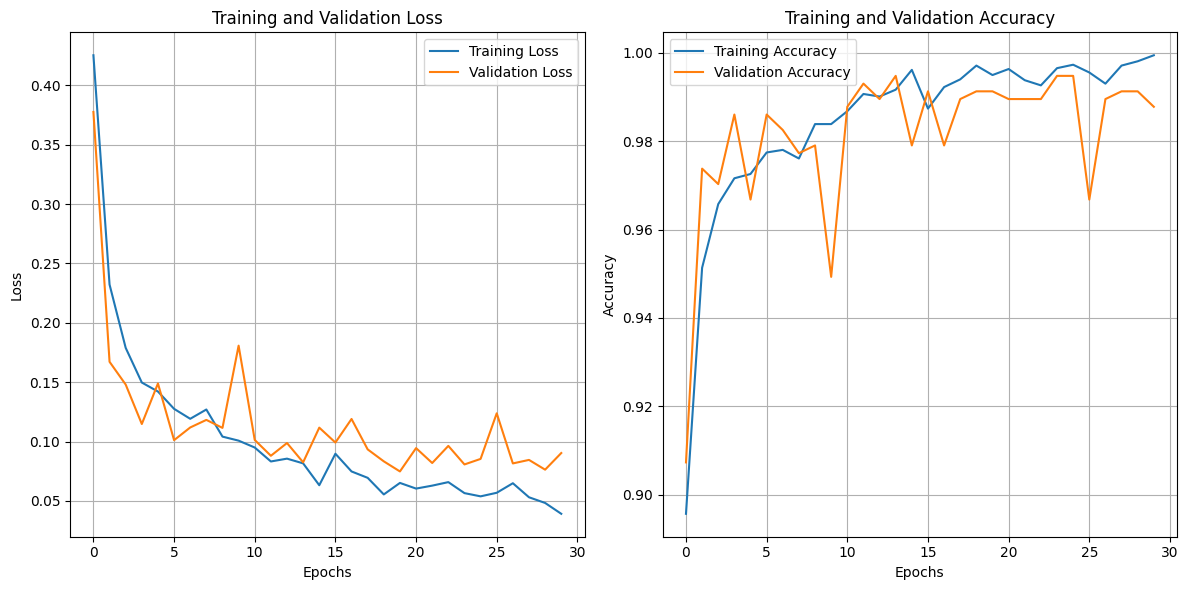

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9974 - loss: 0.0577
Test Loss: 0.0644, Test Accuracy: 0.9939
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


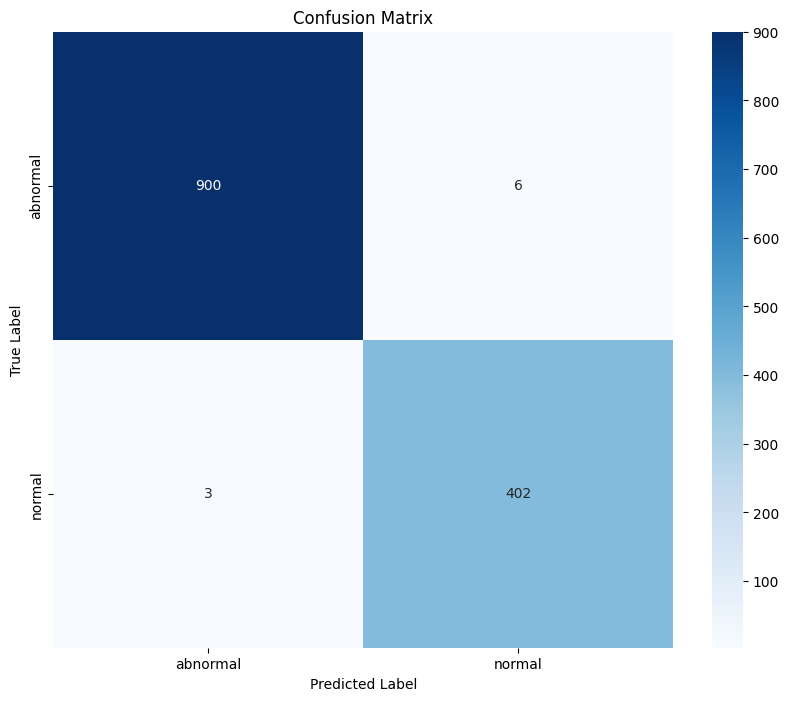

In [ ]:

# Save the model architecture as an image
plot_model(model, to_file=os.path.join(model_dir, 'model_architecture.png'), show_shapes=True)
#
# Save the model architecture as JSON
with open(os.path.join(model_dir, 'model_architecture.json'), 'w') as f:
    f.write(model.to_json())


# Save the training history
hist_df = pd.DataFrame(hist.history)
hist_df.to_csv(os.path.join(model_dir, 'training_history.csv'), index=False)

# Plot Trainign and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'training_validation_loss_accuracy.png'))
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
# Generate predictions on the test set
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(model_dir, 'classification_report.csv'))

# Generate confusion matrix
conf_matrix: tf.Tensor = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(model_dir, 'confusion_matrix.png'))
plt.show()


In [43]:

best_epoch = np.argmin(hist.history['val_loss']) + 1
summary.append(f"Best Epoch: {best_epoch}")
summary.append(f"Best Training Loss: {hist.history['loss'][best_epoch - 1]:.4f}")
summary.append(f"Best Validation Loss: {hist.history['val_loss'][best_epoch - 1]:.4f}")
summary.append(f"Best Training Accuracy: {hist.history['accuracy'][best_epoch - 1]:.4f}")
summary.append(f"Best Validation Accuracy: {hist.history['val_accuracy'][best_epoch - 1]:.4f}")


summary_file = os.path.join(model_dir, 'model_summary.txt')
with open(summary_file, 'w') as f:
    for line in summary:
        f.write(line + '\n')

In [44]:
for line in summary:
    print(line)

================== Model Metadata ================
Model Metadata:
  TensorFlow version: 2.16.2
  Model directory: /Users/dheebz/Workspace/cortex/models
  Model type: classifier
  Model name: cortex-classifier
  Date: 2025-06-09 13:56:32
  Model directory: models/classifier/cortex-classifier-model-20250609-1356
  Epochs: 50
  Batch size: 32
  Patience: 10
  Number of classes: 2
  Image size: 149x149
  Number of training images: 164480
  Number of validation images: 18304
  Number of test images: 41952
  Optimizer: Adam
  Loss function: categorical_crossentropy
Model architecture:
{"module": "keras", "class_name": "Sequential", "config": {"name": "sequential_2", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 149, 149, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_layer_2"}, "re